#CIS 545 Final Project

By Katherine Hann, created Spring 2020.


The motivation for this project comes from my interest in what "healthy eating" really means. It is difficult to define because new data emerges all the time giving updated advice on how to eat healthy. Should we eat foods low in fat? In sugar? Exclusively in trans fat? We will look at the distribution of nutritional data and how each component is correlated with others, which can hopefully shed some light on what healthy means.

 In this notebook, I will try to better understand how to classify foods and recipes as healthy or unhealthy by looking at nutritional data to decide what facts might make a food unhealthy. I then bring in additional data via XPath to determine which are the healthiest of foods in our dataset. I use these two preliminary ideas of healthy vs. unhealthy to build a classifier that determines whether all other foods in the dataset are healthy or not. Lastly, I use these predictions to determine which recipes in an Epicurious dataset are healthiest, and bring in a prices dataset to determine which of those is the most cost effective!

![alt text](http://clipart-library.com/img/718068.jpg)




Run the following two cells to setup the notebook.

In [ ]:
%%capture
!pip3 install py_stringsimjoin
!pip install ipywidgets
!pip install chart_studio
!apt install libkrb5-dev
# !pip install sparkmagic

#Import neccessary libraries
!pip install geocoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import py_stringsimjoin as ssj
import py_stringmatching as sm
from difflib import SequenceMatcher
import requests
from lxml import html
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
# from pyspark.ml.feature import StandardScaler

In [ ]:
url1 = 'https://raw.githubusercontent.com/khann18/545FinalProject/master/nutrition.csv'
nutrition_orig_df = pd.read_csv(url1)

url2 = 'https://raw.githubusercontent.com/khann18/545FinalProject/master/recipes.csv'
recipes_df = pd.read_csv(url2)

url3 = 'https://raw.githubusercontent.com/khann18/545FinalProject/master/prices.csv'
prices_df = pd.read_csv(url3, encoding = "ISO-8859-1")



#Part 1: Working with Nutrition Data

---




We will first explore the data captured in nutrition.csv

Let's visualize the dataframe.

In [ ]:
nutrition_orig_df

,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,0.000 mg,0.000 mg,0.000 mg,0.000 mg,0.00 IU,0.00 mcg,0.00 mcg,0.00 mcg,0.00 mcg,0.00 mcg,0,0.00 mcg,0.000 mg,0.0 mg,0.00 IU,0.00 mg,0.00 mg,0.0 mcg,2.00 mg,0.050 mg,0.47 mg,3.00 mg,0.053 mg,13.00 mg,3.00 mg,2.8 mcg,0.06 mg,0.26 g,0.019 g,0.012 g,0.020 g,0.006 g,0.053 g,0.009 g,0.008 g,0,0.010 g,0.036 g,0.006 g,0.006 g,0.013 g,0.024 g,0.012 g,0.009 g,0.001 g,0.010 g,0.014 g,91.27 g,0.9 g,0.00 g,0,0,0,0,0,0,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,1.167 mg,0.863 mg,0.130 mg,0.660 mg,56.00 IU,3.00 mcg,0.00 mcg,29.00 mcg,9.00 mcg,17.00 mcg,0,0.00 mcg,0.210 mg,1.1 mg,0.00 IU,1.40 mg,1.40 mg,3.5 mcg,70.00 mg,1.200 mg,2.53 mg,121.00 mg,4.500 mg,277.00 mg,410.00 mg,3.8 mcg,4.53 mg,9.17 g,0.397 g,1.177 g,0.929 g,0.152 g,1.829 g,0.453 g,0.262 g,0,0.336 g,0.598 g,0.287 g,0.183 g,0.426 g,0.363 g,0.474 g,0.306 g,0.093 g,0.215 g,0.411 g,13.86 g,9.6 g,3.97 g,0.04 g,0,0.04 g,0.00 g,0.00 g,3.90 g,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,0.649 mg,0.281 mg,0.037 mg,0.039 mg,23.00 IU,1.00 mcg,0.00 mcg,14.00 mcg,0.00 mcg,36.00 mcg,0,0.00 mcg,0.084 mg,2.2 mg,0.00 IU,0.30 mg,0.30 mg,3.5 mcg,9.00 mg,0.081 mg,0.23 mg,14.00 mg,0.232 mg,24.00 mg,229.00 mg,0.3 mcg,0.16 mg,0.98 g,0.051 g,0.057 g,0.164 g,0.006 g,0.186 g,0.041 g,0.023 g,0,0.045 g,0.064 g,0.047 g,0.011 g,0.043 g,0.043 g,0.042 g,0.037 g,0.009 g,0.027 g,0.053 g,5.88 g,3.0 g,3.53 g,1.54 g,0,1.58 g,0,0,0.26 g,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,3.363 mg,0.942 mg,0.270 mg,0.390 mg,9.00 IU,0.00 mcg,0.00 mcg,5.00 mcg,0.00 mcg,66.00 mcg,0,0,0.482 mg,0,0,0.08 mg,0.08 mg,1.9 mcg,180.00 mg,0.810 mg,7.63 mg,184.00 mg,9.240 mg,429.00 mg,427.00 mg,4.4 mcg,3.63 mg,13.30 g,0.747 g,0.517 g,0.820 g,0.236 g,3.349 g,0.477 g,0.301 g,0,0.501 g,1.068 g,0.376 g,0.428 g,0.698 g,0.664 g,0.622 g,0.510 g,0.139 g,0.458 g,0.686 g,73.13 g,8.0 g,1.84 g,0.47 g,0.00 g,0.73 g,0.00 g,0.01 g,0.62 g,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,0.063 mg,0.224 mg,0.097 mg,0.027 mg,46.00 IU,12.00 mcg,0.00 mcg,1.00 mcg,5.00 mcg,7.00 mcg,0,0.13 mcg,0.023 mg,2.3 mg,0.00 IU,0.01 mg,0.01 mg,0.0 mcg,54.00 mg,0.028 mg,0.14 mg,8.00 mg,0.011 mg,40.00 mg,96.00 mg,1.5 mcg,0.48 mg,1.10 g,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.40 g,1.3 g,24.32 g,0,0,0,0,0,0,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8784,"Beef, raw, all grades, trimmed to 0"" fat, separable lean and fat, boneless, top round roast, round",100 g,125,3.5g,1

###1.1 Cleaning Nutrition Dataframe

Almost every column in nutrition_orig_df is listed with units, i.e. g, mg, mcg, or IU. We want to drop these units in order to be able to convert to floats to perform numeric operations on these columns.

We first need to create a new df called nutrition_df and copy over nutrition_orig_df. We print its datatypes below.

In [ ]:
nutrition_df = pd.DataFrame(nutrition_orig_df)
nutrition_df.dtypes

Unnamed: 0       int64
name            object
serving_size    object
calories         int64
total_fat       object
                 ...  
alcohol         object
ash             object
caffeine        object
theobromine     object
water           object
Length: 77, dtype: object

We now want to drop columns that are unneccessary for our analysis. Since pandas created an index on our data, which was the original function of the column "Unnamed: 0", we can drop this column. Also, we know that all serving sizes in this dataset are 100 g, so keeping this column provides no extra information. 

In [ ]:
nutrition_df.drop(columns=['Unnamed: 0', 'serving_size'], inplace=True)

Next, we need to replace all NaNs with 0 since if that value for some nutition fact is NaN we assume that this fact does not apply to the food, for example, an apple has no trans fat.

Lastly, as seen above, some of the columns are ints, so we need to convert these to strings in order to standardize and later pattern match and extract all as floats.

In [ ]:
nutrition_df.fillna(0, axis=0, inplace=True)
nutrition_df.columns

Index(['name', 'calories', 'total_fat', 'saturated_fat', 'cholesterol',
       'sodium', 'choline', 'folate', 'folic_acid', 'niacin',
       'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a',
       'vitamin_a_rae', 'carotene_alpha', 'carotene_beta',
       'cryptoxanthin_beta', 'lutein_zeaxanthin', 'lucopene', 'vitamin_b12',
       'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e', 'tocopherol_alpha',
       'vitamin_k', 'calcium', 'copper', 'irom', 'magnesium', 'manganese',
       'phosphorous', 'potassium', 'selenium', 'zink', 'protein', 'alanine',
       'arginine', 'aspartic_acid', 'cystine', 'glutamic_acid', 'glycine',
       'histidine', 'hydroxyproline', 'isoleucine', 'leucine', 'lysine',
       'methionine', 'phenylalanine', 'proline', 'serine', 'threonine',
       'tryptophan', 'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars',
       'fructose', 'galactose', 'glucose', 'lactose', 'maltose', 'sucrose',
       'fat', 'saturated_fatty_acids', 'monounsaturated_fat

In [ ]:
nutrition_df[nutrition_df.columns[0:-1]] = nutrition_df[nutrition_df.columns[0:-1]].astype(str)
nutrition_df.dtypes

name             object
calories         object
total_fat        object
saturated_fat    object
cholesterol      object
                  ...  
alcohol          object
ash              object
caffeine         object
theobromine      object
water            object
Length: 75, dtype: object

Now, we can finally pattern match in order to extract all floats from our data.

In [ ]:
import re

def extract_num(col):
  temp = re.findall(r'\d+[.\d]*', col)
  list1 = list(map(str, temp))
  return list1[0]

for column in nutrition_df.columns:
  bad_cols = ['name']
  if column not in bad_cols:
    nutrition_df[column] = nutrition_df[column].apply(extract_num)

In [ ]:
nutrition_df[nutrition_df.columns[1:-1]] = nutrition_df[nutrition_df.columns[1:-1]].astype(float)
nutrition_df.dtypes

name              object
calories         float64
total_fat        float64
saturated_fat    float64
cholesterol      float64
                  ...   
alcohol          float64
ash              float64
caffeine         float64
theobromine      float64
water             object
Length: 75, dtype: object

Now, visualize nutrition_df to view our float columns with the dropped units.

In [ ]:
nutrition_df

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,381.0,0.1,0.0,0.0,9.0,0.4,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.0,2.0,0.050,0.47,3.0,0.053,13.0,3.0,2.8,0.06,0.26,0.019,0.012,0.020,0.006,0.053,0.009,0.008,0.000,0.010,0.036,0.006,0.006,0.013,0.024,0.012,0.009,0.001,0.010,0.014,91.27,0.9,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.05,0.009,0.016,0.025,0.0,0.0,0.09,0.0,0.0,8.32
1,"Nuts, pecans",691.0,72.0,6.2,0.0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,17.0,0.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
2,"Eggplant, raw",25.0,0.2,0.0,0.0,2.0,6.9,22.0,0.0,0.649,0.281,0.037,0.039,23.0,1.0,0.0,14.0,0.0,36.0,0.0,0.00,0.084,2.2,0.0,0.30,0.30,3.5,9.0,0.081,0.23,14.0,0.232,24.0,229.0,0.3,0.16,0.98,0.051,0.057,0.164,0.006,0.186,0.041,0.023,0.000,0.045,0.064,0.047,0.011,0.043,0.043,0.042,0.037,0.009,0.027,0.053,5.88,3.0,3.53,1.54,0.0,1.58,0.0,0.00,0.26,0.18,0.034,0.016,0.076,0.0,0.0,0.66,0.0,0.0,92.30
3,"Teff, uncooked",367.0,2.4,0.4,0.0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,66.0,0.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
4,"Sherbet, orange",144.0,2.0,1.2,1.0,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,7.0,0.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,"Beef, raw, all grades, trimmed to 0"" fat, separable lean and fat, boneless, top round roast, round",125.0,3.5,1.4,62.0,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
8785,"Lamb, cooked, separable lean only, composite of trimmed retail cuts, frozen, imported, New Zealand",206.0,8.9,3.9,109.0,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.605,0.353,4.294,1.445,0.937,0.000,1.428,2.302,2.613,0.759,1.205,1.241,1.100,1.267,0.346,0.995,1.597,0.00,0.0,0.00,0.

###1.2 Simplifying the Data to Visualize



We want to better understand the data we have in nutrition_df. We notice that all columns have titles like "Beef, raw, all grades, trimmed to 0" fat, separable lean only, boneless, eye of round steak, round." This isn't very useful for us to better understand the data, because although our data considers this to be completely different from "Beef, raw, all grades, trimmed to 0" fat, separable lean only, boneless, eye of round roast, round", we don't want them to be looked at as completely different foods when we visualize our data, and when we suggest healthy foods.

We will preserve all the information we currently have in nutrition_df by making a new dataframe with the simplified data for visualization called nutrition_small_df.

If we want to make more general names, we first notice that all classifying terms are separated by commas in our name column. So, we first make one big list with all comma separated pieces of all titles in order to count the occurrences of terms throughout the name column. This will help us figure out, for example, if "raw" or "cooked" is useful to the name of the row, or if it is an irrelevant classifier for our purposes (both of these examples would be irrelevant).

In [ ]:
def split(col):
  return col.split(',')

temp_df = pd.DataFrame()
temp_df = nutrition_df.copy()
temp_df['name'] = temp_df['name'].apply(split)
names_final_list = []
names_final_list = temp_df.name.to_list()
names_final_list

[['Cornstarch'],
 ['Nuts', ' pecans'],
 ['Eggplant', ' raw'],
 ['Teff', ' uncooked'],
 ['Sherbet', ' orange'],
 ['Cauliflower', ' raw'],
 ['Taro leaves', ' raw'],
 ['Lamb', ' raw', ' ground'],
 ['Cheese', ' camembert'],
 ['Vegetarian fillets'],
 ['PACE', ' Picante Sauce'],
 ['Goji berries', ' dried'],
 ['Mango nectar', ' canned'],
 ['Crackers', ' rusk toast'],
 ['Chicken', ' boiled', ' feet'],
 ['Quail', ' raw', ' meat only'],
 ['Pie', ' lemon', ' fried pies'],
 ['Peppers', ' raw', ' jalapeno'],
 ['Winged bean tuber', ' raw'],
 ['Salami', ' turkey', ' cooked'],
 ['Grapes', ' raw', ' muscadine'],
 ['Nuts', ' raw', ' ginkgo nuts'],
 ['Spices', ' ground', ' savory'],
 ['Candies', ' sesame crunch'],
 ['Cheese', ' low fat', ' cream'],
 ['PACE', ' Green Taco Sauce'],
 ['Syrup', ' Canadian', ' maple'],
 ['Ostrich', ' raw', ' top loin'],
 ['Chewing gum', ' sugarless'],
 ['Nuts', ' dried', ' pine nuts'],
 ['Pasta', ' unenriched', ' dry'],
 ["McDONALD'S", ' Side Salad'],
 ['Cookies', ' Marie bis

In [ ]:
from collections import OrderedDict
def CountFrequency(my_list): 
  freq = {} 
  for item in my_list: 
    for item2 in item:
      if (item2 in freq): 
        freq[item2] += 1
      else: 
        freq[item2] = 1
  return freq 
  
occurrences_map = CountFrequency(names_final_list) 
   
occurrences_sorted = OrderedDict(sorted(occurrences_map.items(), key = lambda kv:(kv[1], kv[0]), reverse=True))
occurrences_sorted

OrderedDict([(' cooked', 1730),
             (' raw', 1337),
             ('Beef', 961),
             (' separable lean and fat', 770),
             (' separable lean only', 661),
             (' canned', 502),
             (' boneless', 489),
             (' trimmed to 0" fat', 467),
             (' frozen', 408),
             (' trimmed to 1/8" fat', 396),
             (' roasted', 360),
             (' boiled', 356),
             (' choice', 338),
             ('Pork', 324),
             (' fresh', 306),
             ('Lamb', 295),
             (' imported', 289),
             (' drained', 287),
             ('Beverages', 282),
             ('Cereals ready-to-eat', 258),
             (' all grades', 255),
             (' without salt', 247),
             (' braised', 246),
             ('Babyfood', 243),
             (' select', 243),
             (' with salt', 239),
             (' loin', 239),
             ('Fish', 231),
             ('Chicken', 204),
             (' unprepared',

We will consider a term to be a common descriptor term if it occurs more than 10 times in the dataset, and is not the first word in the name. We make this additional distinction because, for example, beef occurs 961 times in our dataset, but it is not just a descriptor term because it is the first word in the name and therefore defines the rest of the name.

We now remove all "common descriptor" words.

In [ ]:
def shorten(col):
  l = col.split(",")
  to_return = [l[0]]
  if len(l) > 1:
    for item in l[1:]:
      if len(item) < 17 and occurrences_map[item] < 10 and len(item) > 1 and not any(s in item for s in nutrition_df.columns) : 
        to_return.append(item)
  my_string = ','.join(to_return)
  return my_string

nutrition_small_df = pd.DataFrame()
nutrition_small_df = nutrition_df.copy()

nutrition_small_df['name'] = nutrition_small_df['name'].apply(shorten)
nutrition_small_df

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,381.0,0.1,0.0,0.0,9.0,0.4,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.0,2.0,0.050,0.47,3.0,0.053,13.0,3.0,2.8,0.06,0.26,0.019,0.012,0.020,0.006,0.053,0.009,0.008,0.000,0.010,0.036,0.006,0.006,0.013,0.024,0.012,0.009,0.001,0.010,0.014,91.27,0.9,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.05,0.009,0.016,0.025,0.0,0.0,0.09,0.0,0.0,8.32
1,"Nuts, pecans",691.0,72.0,6.2,0.0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,17.0,0.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
2,Eggplant,25.0,0.2,0.0,0.0,2.0,6.9,22.0,0.0,0.649,0.281,0.037,0.039,23.0,1.0,0.0,14.0,0.0,36.0,0.0,0.00,0.084,2.2,0.0,0.30,0.30,3.5,9.0,0.081,0.23,14.0,0.232,24.0,229.0,0.3,0.16,0.98,0.051,0.057,0.164,0.006,0.186,0.041,0.023,0.000,0.045,0.064,0.047,0.011,0.043,0.043,0.042,0.037,0.009,0.027,0.053,5.88,3.0,3.53,1.54,0.0,1.58,0.0,0.00,0.26,0.18,0.034,0.016,0.076,0.0,0.0,0.66,0.0,0.0,92.30
3,Teff,367.0,2.4,0.4,0.0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,66.0,0.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
4,Sherbet,144.0,2.0,1.2,1.0,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,7.0,0.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,Beef,125.0,3.5,1.4,62.0,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
8785,Lamb,206.0,8.9,3.9,109.0,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.605,0.353,4.294,1.445,0.937,0.000,1.428,2.302,2.613,0.759,1.205,1.241,1.100,1.267,0.346,0.995,1.597,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95
8786,Lamb,277.0,23.0,12.0,78.0,39.0,0.0,1.0,0.0,6.550,0.520,0.320,0.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.42,0.110,0.0,0.0,0.21,0.21,0.0,13.0,0.083,

Now what we want to do is group columns by shortened name, and take the average of all statistics to update the columns for a group's statistics.

We also change the 'name' from being the new index to just being a column, using reset_index.

In [ ]:
nutrition_small_df = nutrition_small_df.groupby('name').mean()
nutrition_small_df.reset_index(inplace=True)
nutrition_small_df

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine
0,ANDREA'S,257.0,8.200000,0.000000,0.0,544.000000,0.000000,31.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.140,0.000000,0.000000,0.520000,0.520000,0.000000,41.0,0.1110,0.890000,42.0,0.671000,128.0,165.000000,9.200000,0.770000,5.650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,40.240000,2.90,2.980000,1.55,0.000,1.250,0.000,0.180,0.000,8.20,0.0000,0.000000,0.0000,0.0,0.0,1.310000,0.0,0.0
1,APPLEBEE'S,296.2,16.420000,4.000000,50.0,770.600000,10.020000,2.800000,0.0,3.008000,0.634000,0.182000,0.084600,106.0,26.2,0.2,11.800000,3.2,25.800000,0.0,0.712,0.256,0.000000,0.000000,1.154000,1.154000,18.480000,85.0,0.0862,1.020000,22.8,0.255600,233.6,204.800000,18.340000,1.854000,15.646,0.799400,0.969800,1.340400,0.203000,3.136600,0.643,0.510000,0.008,0.778,1.352400,1.180200,0.394,0.7128,1.109,0.564800,0.570000,0.191800,0.534400,0.875600,21.396000,1.76,1.742000,0.25,0.054,0.478,0.208,0.456,0.296,16.44,3.9992,4.319000,6.4182,50.0,0.0,2.710000,0.0,0.0
2,"APPLEBEE'S, chili",157.0,9.800000,4.200000,45.0,381.000000,0.000000,0.000000,0.0,3.557000,0.405000,0.207000,0.037000,1436.0,149.0,0.0,577.000000,200.0,367.000000,0.0,1.260,0.321,1.100000,0.000000,1.150000,1.150000,0.000000,34.0,0.0860,1.460000,18.0,0.084000,104.0,320.000000,13.100000,2.230000,12.560,0.793000,0.772000,1.195000,0.123000,2.070000,0.834,0.371000,0.240,0.556,0.927000,0.844000,0.278,0.4740,0.855,0.371000,0.402000,0.144000,0.340000,0.639000,4.570000,1.40,2.270000,0.98,0.000,1.070,0.000,0.000,0.220,9.79,4.1500,4.809000,0.6440,45.0,0.0,1.760000,0.0,0.0
3,"APPLEBEE'S, coleslaw",120.0,7.100000,1.100000,2.0,178.000000,0.000000,0.000000,0.0,0.300000,0.205000,0.063000,0.030000,1504.0,77.0,425.0,685.000000,2.0,53.000000,0.0,0.000,0.129,13.700000,0.000000,0.500000,0.500000,65.100000,36.0,0.0170,0.260000,10.0,0.148000,23.0,156.000000,0.400000,0.190000,0.790,0.034000,0.059000,0.068000,0.008000,0.127000,0.017,0.008000,0.000,0.025,0.034000,0.017000,0.008,0.0170,0.006,0.017000,0.017000,0.006000,0.008000,0.034000,13.170000,2.80,9.330000,2.24,0.000,2.530,0.000,0.000,4.560,7.09,1.0610,1.404000,3.8190,2.0,0.0,0.790000,0.0,0.0
4,"APPLEBEE'S, french fries",290.0,13.000000,2.300000,1.0,618.000000,0.000000,0.000000,0.0,2.180000,0.495000,0.058000,0.103000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.205,0.700000,0.000000,0.930000,0.930000,33.400000,19.0,0.1090,1.010000,29.0,0.268000,137.0,538.000000,0.400000,0.490000,3.310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,39.500000,3.90,0.000000,0.00,0.000,0.000,0.000,0.000,0.000,13.17,2.3330,3.310000,5.8020,1.0,0.0,2.720000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,"Yogurt, skim milk",56.0,0.200000,0.100000,2.0,77.000000,15.200000,12.000000,0.0,0.124000

#Part 2 Visualizing Our Nutrition Data

We want to figure out more information about our data through visualization, especially if there is a correlation between some commonly assumed "good" food qualities, and "bad" ones (such as sugar, saturated fat, etc.) 

###2.1 Correlation between features


We will start out by looking at the correlation matrix for our data. The code here is adapted from the code in HW1.

In [ ]:
correlation_matrix = nutrition_small_df.drop(columns=['name']).corr()
correlation_matrix

,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine
calories,1.000000,0.822966,0.615783,0.053839,0.014254,0.064631,0.144075,0.114912,0.163482,0.059914,0.120121,0.127386,0.002781,0.082035,-0.024793,-0.057712,-0.007577,-0.060531,NaN,-0.017657,0.117179,-0.056477,0.072511,0.329407,0.329407,-0.007091,0.090071,0.184606,0.144843,0.229636,0.056428,0.177146,0.049967,0.073678,0.168127,0.138121,0.036089,0.099048,0.055936,0.104366,0.115546,0.058275,0.044208,-0.004931,0.039507,0.054797,-0.008745,0.019194,0.083942,0.115319,0.090866,0.028324,0.062862,0.060034,0.057745,0.445769,0.161869,0.254112,-0.055624,0.005991,-0.027769,0.035387,0.055445,0.092279,0.822925,0.615638,0.696647,0.606311,0.053839,-0.041482,0.034690,0.017165,0.086210
total_fat,0.822966,1.000000,0.748106,0.131070,0.000401,0.060618,-0.052741,-0.050680,-0.028152,0.004025,-0.037483,-0.004088,0.005976,0.089343,-0.029977,-0.048151,-0.006540,-0.049327,NaN,-0.031592,-0.058275,-0.062225,0.087392,0.374483,0.374483,0.014515,0.008998,0.079857,-0.047099,0.060231,0.010112,0.055519,-0.048296,0.052604,0.018524,0.050116,0.042556,0.105895,0.060332,0.060486,0.078563,0.053650,0.064629,0.027734,0.051248,0.059117,0.032280,0.047256,0.069779,0.074190,0.077427,0.045334,0.057342,0.074922,0.063363,-0.093780,-0.031939,-0.047186,-0.078944,-0.007288,-0.058649,0.025736,-0.026511,0.000590,0.999965,0.748135,0.862308,0.719894,0.131070,-0.062529,-0.021774,-0.013600,0.037609
saturated_fat,0.615783,0.748106,1.000000,0.136882,0.003003,0.054421,-0.060959,-0.043016,-0.065202,-0.003689,-0.031289,-0.036184,-0.011609,0.059392,-0.025471,-0.044584,-0.012941,-0.047410,NaN,-0.019045,-0.078456,-0.048809,0.051713,0.149994,0.149994,-0.002285,0.041396,0.011019,-0.062359,-0.026582,-0.010539,0.032932,-0.060606,0.026526,0.006734,0.025102,0.027720,0.041847,0.028427,0.021138,0.063985,0.025977,0.064109,0.021884,0.056992,0.062647,0.055124,0.055856,0.059319,0.096848,0.066011,0.044961,0.052122,0.083809,0.069958,-0.073305,-0.073688,0.032513,-0.066362,0.005691,-0.047922,0.035940,-0.019642,0.006828,0.748104,0.999933,0.493799,0.268976,0.136882,-0.046041,-0.022065,-0.006356,0.086488
cholesterol,0.053839,0.131070,0.136882,1.000000,0.010379,0.567387,-0.041389,-0.048043,0.025082,0.192804,0.100483,-0.037092,0.049579,0.135772,-0.017261,-0.037827,-0.011958,-0.016333,NaN,0.322205,-0.002332,-0.034618,0.147005,-0.033803,-0.033803,-0.038931,-0.004412,0.000195,-0.003700,-0.064493,-0.027399,0.128501,-0.018565,0.172834,0.092171,0.313386,0.318727,0.269278,0.279129,0.322075,0.252977,0.213616,0.313383,0.129625,0.350433,0.344960,0.361354,0.376949,0.322771,0.232537,0.356631,0.358275,0.329375,0.343920,0.352358,-0.227295,-0.143315,-0.133690,-0.048834,-0.003158,-0.043610,-0.007637,-0.021463,-0.033389,0.130837,0.137168,0.127071,0.020920,1.000000,-0.031758,0.009108,-0.010998,-0.020556
sodium,0.014254,0.000401,0.003003,0.010379,1.000000,0.023771,0.035670,0.043643,0.042334,-0.007164,0.054094,0.055730,-0.009033,0.002061,-0.004349,-0.006711,0.003883,-0.020063,NaN,0.009762,-0.002636,-0.024150,-0.007134,-0.016523,-0.016523,-0.016161,0.189007,-0.031357,0.019067,-0.018288,-0.009804,0.102134,0.001074,0.010405,0.021534,0.052496,0.012774,-0.005404,0.001530,0.001058,0.013530,0.024412,0.004479,0.005695,0.005903,0.007414,0.007039,0.002602,0.008682,0.04184

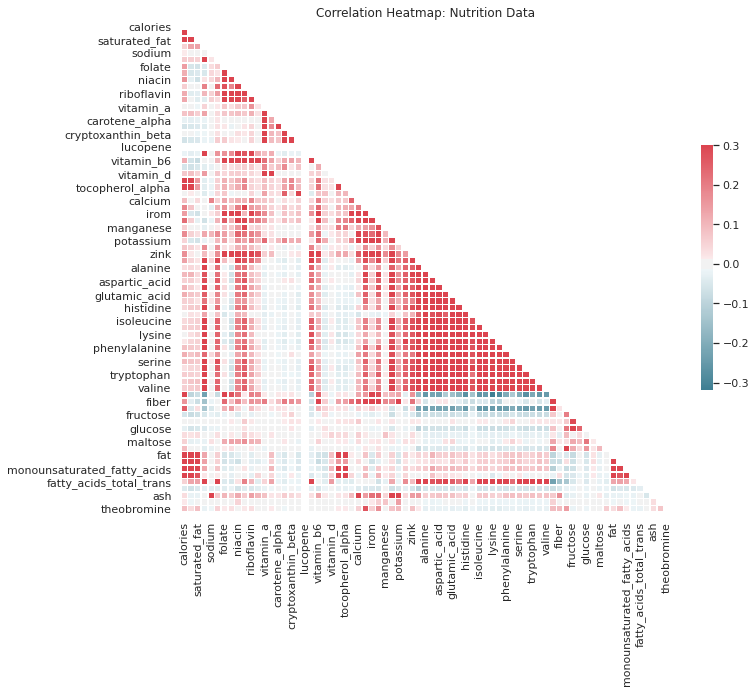

In [ ]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
#ASSIGN THE "corr" VARIABLE TO YOUR CORRELATION MATRIX
corr = correlation_matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Nutrition Data")
plt.show()

Now, we want to further explore an assumption we make that is fairly obvious and looks to be confirmed by our correlation matrix: foods higher in fat are higher in calories. As seen below, this correlation is very strong. 

Slope:  8.366494806153291
The correlation is:  0.8229658956282391
The pvalue here is: 0.0


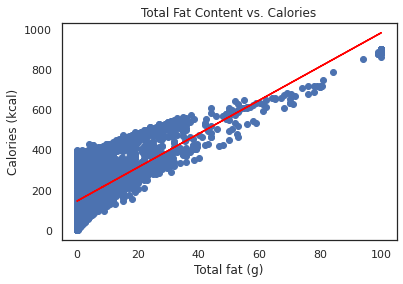

In [ ]:
from scipy.stats import linregress

# calories (measured in kCal) on the y axis, total fat (measured in grams) on the x axis
x = nutrition_small_df.total_fat
y = nutrition_small_df.calories

stats = linregress(x, y)

m = stats.slope
b = stats.intercept
print('Slope: ', m)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, m * x + b, color="red")

ax.set_title('Total Fat Content vs. Calories')
ax.set_ylabel('Calories (kcal)')
ax.set_xlabel('Total fat (g)')

correlation = stats.rvalue
print('The correlation is: ', correlation)
print('The pvalue here is:', stats.pvalue)

Since the correlation value is 0.82, and the p value is 0, this means that these two variables are strongly correlated, and there is essentially no possibility of obtaining these results by chance.

The slope indicates that each additional gram of fat in a food leads to about 8.4 additional calories.

I was also wondering, what is the difference between the column labeled 'saturated fat' and the column for 'saturated fatty acids'? To figure this out, we create a scatterplot to see how correlated the two are. Note that they are both measured in grams. We do the same for 'total_fat' and 'fat' since there is no obvious difference here either.

Slope:  0.9998057542698274
The correlation is:  0.9999329730046899
The pvalue here is: 0.0


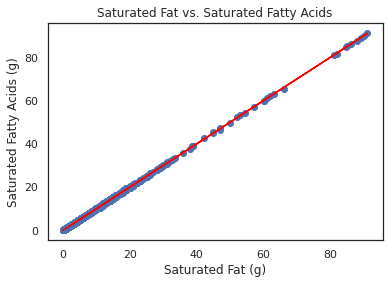

In [ ]:
from scipy.stats import linregress

# saturated fat (g) on the x axis, saturated fatty acids (measured in grams) on the y axis
x = nutrition_small_df.saturated_fat
y = nutrition_small_df.saturated_fatty_acids

stats = linregress(x, y)

m = stats.slope
b = stats.intercept
print('Slope: ', m)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, m * x + b, color="red")

ax.set_title('Saturated Fat vs. Saturated Fatty Acids')
ax.set_xlabel('Saturated Fat (g)')
ax.set_ylabel('Saturated Fatty Acids (g)')

correlation = stats.rvalue
print('The correlation is: ', correlation)
print('The pvalue here is:', stats.pvalue)

We can see above that the correlation is almost 1, with a p-value of 0. Thus they are essentially identical.

Slope:  0.9996671736285294
The correlation is:  0.9999652463971902
The pvalue here is: 0.0


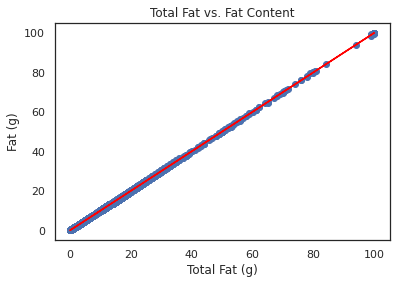

In [ ]:
from scipy.stats import linregress

# total fat (measured in grams) on the x axis, fat (measured in grams) on the y axis
x = nutrition_small_df.total_fat
y = nutrition_small_df.fat

stats = linregress(x, y)

m = stats.slope
b = stats.intercept
print('Slope: ', m)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, m * x + b, color="red")

ax.set_title('Total Fat vs. Fat Content')
ax.set_xlabel('Total Fat (g)')
ax.set_ylabel('Fat (g)')

correlation = stats.rvalue
print('The correlation is: ', correlation)
print('The pvalue here is:', stats.pvalue)

Again, we see a correlation of about 1 and a p-value of 0. Thus these two columns are also essentially identical. 

Since we have 2 sets of columns that are essentially identical, having both does not benefit our dataset. So, below we choose to drop the columns for 'saturated fatty acids' and 'fat'.

In [ ]:
nutrition_small_df.drop(columns=['saturated_fatty_acids', 'fat'], inplace=True)
nutrition_df.drop(columns=['saturated_fatty_acids', 'fat'], inplace=True)

There may be other columns that the user wants to compare, so we present an interactive plot below that allows the user to compare the two columns of interest.

In [ ]:
import cufflinks as cf
from plotly.offline import iplot
from scipy.stats import linregress
from ipywidgets import interact, interact_manual


@interact
def scatter_plot(x=list(nutrition_small_df.select_dtypes('number').columns), 
                 y=list(nutrition_small_df.select_dtypes('number').columns)):
    
    
  stats = linregress(nutrition_small_df[x], nutrition_small_df[y])

  m = stats.slope
  b = stats.intercept
  print('Slope: ', m)

  fig, ax = plt.subplots()
  ax.scatter(nutrition_small_df[x], nutrition_small_df[y], c='blue')
  ax.plot(nutrition_small_df[x], m * nutrition_small_df[x] + b, color="pink")

  title = x + ' vs. ' + y
  ax.set_title(title)
  ax.set_xlabel(x)
  ax.set_ylabel(y)

  correlation = stats.rvalue
  print('The correlation is: ', correlation)
  print('The pvalue here is:', stats.pvalue)

interactive(children=(Dropdown(description='x', options=('calories', 'total_fat', 'saturated_fat', 'cholestero…

###2.2 Nutrition Facts Distribution

Now, we want to look at the distribution of protein and carbs in our dataset, in hopes that this will give us a better sense of how much of the food in the dataset is healthy vs. unhealthy. Is it a normal distribution, or skewed?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c23caf748>,
      dtype=object)

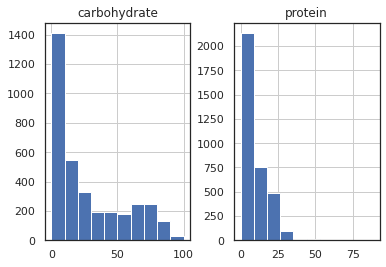

In [ ]:
nutrition_small_df.hist(column=['protein', 'carbohydrate'])

Protein is even farther right skewed than carbohyrates. There appear to be very, very few foods with greater than or equal to 50 grams of protein. (This is an indication of more carb-heavy foods and fewer protein-heavy foods, which may be an indication that there are more unhealthy foods than healthy foods in nutrition_df). 

The 50 grams cutoff is significant because every serving is 100 grams. It would be interesting to know what foods these are that are almost entirely protein.

In [ ]:
high_protein_foods = nutrition_small_df[ nutrition_small_df['protein'] >= 50 ].name
high_protein_foods

333                       Beverages, ABBOTT
696                      Caribou, rump meat
697                  Caribou, shoulder meat
1183                        Egg, stabilized
1184                Egg, stabilized, flakes
1494            Gelatin desserts, vitamin C
1495                   Gelatins, dry powder
2594         Protein supplement, milk based
2788                  Salmon, red (sockeye)
2859                                   Seal
2902                                  Smelt
2930    Snacks, barbecue-flavor, pork skins
2964                     Snacks, pork skins
3064                Soy protein concentrate
3065                    Soy protein isolate
3375                     Vital wheat gluten
Name: name, dtype: object

As expected, these are foods are recognizable as primarily used for their high protein content.

In part 3, we will discover similar information about carbohydrates. 

Overall, we want to see what foods appear in what "brackets" of health. This will help us better understand how to choose the correct ranges defining unhealthy foods. 

Below we create a slider to visualize sugars, total_fat, and saturated_fat. All are measured in grams and the original serving size for each row is 100 grams, so our slider ranges from 0 to 100 g, as this is the highest that any of these values could be.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy.stats import norm


@interact
def show_df(column=['sugars', 'total_fat', 'saturated_fat'], x=(0, 100, 1)):
    return nutrition_small_df.loc[nutrition_small_df[column] > x]

interactive(children=(Dropdown(description='column', options=('sugars', 'total_fat', 'saturated_fat'), value='…

We also have columns whose values are not well represented by a range of 0 to 100 grams (since some nutrition contents naturally occur in smaller quantities, and some are scaled differently, either in mg or IU).

To better show these, we make a new slider that represents the percentile among the dataset. For example, if the slider is at 90 and 'calories' is selected, the table below will present all rows that have more calories than 90% of the dataset (in the top 10th percentile of calories).

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_df(column=list(nutrition_small_df.select_dtypes('number').columns), x=(0, 100, 1)):
    return nutrition_small_df.loc[nutrition_small_df[column] > nutrition_small_df[column].quantile(x / 100)]


interactive(children=(Dropdown(description='column', options=('calories', 'total_fat', 'saturated_fat', 'chole…

#Part 3: Decide What's Healthy and Unhealthy

###3.1 Deciding on unhealthy foods based on nutrition facts
We make lists of foods high in carbs, high in sugars, and high in total fat. These high quantities of any of these 3 categories is known to generally indicate unhealthy foods.

First, we consider all foods with greater than or equal to 80% of its serving size to be carbs "high carb foods." This is because at lower levels, foods such as spices and some fruits are mistaken as "unhealthy" since they are high in carbs, but high in other redeeming categories.

In [ ]:
high_carbs_foods = nutrition_small_df[ nutrition_small_df['carbohydrate'] >= 80 ].name.to_list()
high_carbs_foods

['Arrowroot flour',
 'Babyfood, fruit medley, juice treats',
 'Babyfood, pretzels',
 'Babyfood, rice and apples',
 'Beverages, Lemonade',
 'Beverages, OVALTINE',
 'Beverages, lemon-flavored',
 'Beverages, orange flavor, GATORADE, QUAKER OATS, drink mix',
 'Beverages, rich chocolate',
 'Butter replacement',
 'Cake, pudding-type',
 'Candied fruit',
 'Candies, Fruit and Creme',
 'Candies, Original fruits',
 'Candies, TOOTSIE ROLL',
 'Candies, Tamarind',
 'Candies, Tropical fruits',
 'Candies, YORK BITES',
 'Candies, caramels',
 'Candies, divinity',
 'Candies, fondant',
 'Candies, fruit snacks',
 'Candies, gum drops',
 'Candies, gumdrops',
 'Candies, jellybeans',
 'Candies, marshmallows',
 'Candies, taffy',
 'Candies, with almonds, nougat',
 'Carob flour',
 'Cereals ready-to-eat',
 'Cereals ready-to-eat, ALPHA-BITS',
 'Cereals ready-to-eat, Apple ZINGS',
 'Cereals ready-to-eat, BERRY BERRY KIX',
 'Cereals ready-to-eat, BOO BERRY',
 'Cereals ready-to-eat, Banana Nut, CHEERIOS',
 'Cereals re

We create the final list of unhealthy foods, and add to it all foods that are high in fat and high in sugar, or high in carbs, or high in saturated fat. This serves as a way to weed out good fats, which will be lower in saturated fat, sugar, and carbs than something like a fried food.

Through trial and error, and visualizing the output of the list, we determine that the sugar should be at least 1/2 standard deviation above the mean sugar because otherwise we will classify fruits as unhealthy. We determine that the fat cutoff should be lower, just at the mean, since we are scanning everything in this for also being in high carbs, sugar, or saturated fat. 

Lastly, since we have a long list of alcoholic beverages in our dataset too, we will classify anything with alcohol content above 0 as unhealthy.

In [ ]:
unhealthy_foods = []

sugar_mean = nutrition_small_df['sugars'].mean()
sugar_stdev = nutrition_small_df['sugars'].std()

too_much_sugar = sugar_stdev/2 + sugar_mean

high_sugar_foods = nutrition_small_df[nutrition_small_df['sugars'] >= too_much_sugar].name.to_list()

fat_mean = nutrition_df['total_fat'].mean()
fat_stdev = nutrition_df['total_fat'].std()

too_much_fat = fat_mean

high_fat_foods = nutrition_small_df[nutrition_small_df['total_fat'] >= too_much_fat].name.to_list()

sat_fat_mean = nutrition_df['saturated_fat'].mean()
sat_fat_stdev = nutrition_df['saturated_fat'].std()
high_sat_fat_foods = nutrition_small_df[nutrition_small_df['saturated_fat'] >= sat_fat_mean].name.to_list()


for food in high_fat_foods:
  if food in high_carbs_foods or food in high_sugar_foods or food in high_sat_fat_foods:
    unhealthy_foods.append(food)
print(len(unhealthy_foods))

for al in nutrition_small_df[nutrition_small_df['alcohol'] > 0].name.to_list():
  if al not in unhealthy_foods:
    unhealthy_foods.append(al)
unhealthy_foods


968


["APPLEBEE'S",
 'ARCHWAY Home Style Cookies',
 'ARCHWAY Home Style Cookies, Dutch Cocoa',
 'ARCHWAY Home Style Cookies, Frosty Lemon',
 'ARCHWAY Home Style Cookies, Iced Molasses',
 'ARCHWAY Home Style Cookies, Iced Oatmeal',
 'ARCHWAY Home Style Cookies, Molasses',
 'ARCHWAY Home Style Cookies, Oatmeal',
 'ARCHWAY Home Style Cookies, Oatmeal Raisin',
 'ARCHWAY Home Style Cookies, Peanut Butter',
 'AUSTIN',
 'AUSTIN, PB & J Crackers',
 'Agutuk',
 'Alcoholic beverage, 34 proof, liqueur',
 'Animal fat, bacon grease',
 'BANQUET, family size',
 'BARBARA DEE',
 'BEAR NAKED',
 'BURGER KING',
 'BURGER KING, Cheeseburger',
 'BURGER KING, DOUBLE WHOPPER',
 'BURGER KING, Egg and Cheese',
 'BURGER KING, Hamburger',
 'BURGER KING, Onion Rings',
 'BURGER KING, WHOPPER',
 'BURGER KING, no cheese, DOUBLE WHOPPER',
 'BURGER KING, no cheese, WHOPPER',
 'Babyfood, LIL CRUNCHIES, GRADUATES, Snack',
 'Babyfood, baby, cookie',
 'Babyfood, chicken sticks',
 'Babyfood, cookies',
 'Babyfood, meat sticks',
 'B

###3.2 Gather more data on what is healthy

Here, we access an article from BBC that has a list of the 100 most nutritious foods. I will use the xpath technique to access the page's html and iterate through to find the 100 foods in the list.

In [ ]:
import requests
from lxml import html

content = requests.get('https://www.bbc.com/future/article/20180126-the-100-most-nutritious-foods')
tree = html.fromstring(content.content)

import re

def extract_line(line):
  temp = re.findall(r'\d+\. ', line)
  list1 = list(map(str, temp))
  if len(list1) > 0 and 'kcal' not in list1[0]:
    return True
  else:
    return False

def extract_text(line):
  temp = re.findall(r' \D+', line)
  list1 = list(map(str, temp))
  item = list1[0][1:]
  item = item.lower()
  if '(v)' in item:
    return item[0:-4]
  return item

foods_list = []
for div in tree.xpath('//*[@id="futurearticle20180126-the-100-most-nutritious-foods"]/div[2]/div/div/article/div/div'):
  items = div.itertext()
  # print(items)
  for i in items:
    if extract_line(i):
      foods_list.append(i)

healthy_foods = []
for item in foods_list:
  healthy_foods.append(extract_text(item))

healthy_foods

['sweet potato',
 'figs',
 'ginger',
 'pumpkin',
 'burdock root',
 'brussels sprouts',
 'broccoli',
 'cauliflower',
 'water chestnuts',
 'cantaloupe melons',
 'prunes',
 'common octopus ',
 'carrots',
 'winter squash',
 'jalapeno peppers',
 'rhubarb',
 'pomegranates',
 'red currants',
 'oranges',
 'carp',
 'hubbard squash',
 'kumquats',
 'pompano ',
 'pink salmon ',
 'sour cherries',
 'rainbow trout',
 'perch',
 'green beans',
 'red leaf lettuce',
 'leeks',
 'cayenne pepper',
 'green kiwifruit',
 'golden kiwifruit',
 'grapefruit',
 'mackerel',
 'sockeye salmon',
 'arugula',
 'chives',
 'paprika',
 'red tomatoes',
 'green tomatoes',
 'green lettuce',
 'taro leaves',
 'lima beans',
 'eel',
 'bluefin tuna',
 'coho salmon',
 'summer squash',
 'navy beans',
 'plantain',
 'podded peas',
 'cowpeas',
 'butter lettuce',
 'red cherries',
 'walnuts',
 'fresh spinach',
 'parsley',
 'herring',
 'sea bass',
 'chinese cabbage',
 'cress',
 'apricots',
 'fish roe',
 'whitefish',
 'coriander',
 'romaine

However, since this is a list of the most nutritious foods in terms of certain vitamins and special properties, we have few fruits included in this list. In order for the classifier to recognize that something can be relatively high in sugar and still be healthy, we search another site using XPath, called Half Your Plate, that gives a list of the most common fruits.

We add all of these fruits to healthy_foods list if they are not already there.

In [ ]:
import requests
from lxml import html

content = requests.get('https://www.halfyourplate.ca/fruits-and-veggies/fruits-a-z/')
tree = html.fromstring(content.content)

import re

foods_list = []
for div in tree.xpath('/html/body/div[4]/div[2]/ul/li'):
  items = div.itertext()
  
  for i in items:
    temp = re.findall(r'\D+', i)
    list1 = list(map(str, temp))
    if len(list1) > 0:
      if '\n' not in list1[0] and '\t' not in list1[0]:
        foods_list.append(list1[0].lower())

for item in foods_list:
  if item not in healthy_foods:
    healthy_foods.append(item)
healthy_foods


['sweet potato',
 'figs',
 'ginger',
 'pumpkin',
 'burdock root',
 'brussels sprouts',
 'broccoli',
 'cauliflower',
 'water chestnuts',
 'cantaloupe melons',
 'prunes',
 'common octopus ',
 'carrots',
 'winter squash',
 'jalapeno peppers',
 'rhubarb',
 'pomegranates',
 'red currants',
 'oranges',
 'carp',
 'hubbard squash',
 'kumquats',
 'pompano ',
 'pink salmon ',
 'sour cherries',
 'rainbow trout',
 'perch',
 'green beans',
 'red leaf lettuce',
 'leeks',
 'cayenne pepper',
 'green kiwifruit',
 'golden kiwifruit',
 'grapefruit',
 'mackerel',
 'sockeye salmon',
 'arugula',
 'chives',
 'paprika',
 'red tomatoes',
 'green tomatoes',
 'green lettuce',
 'taro leaves',
 'lima beans',
 'eel',
 'bluefin tuna',
 'coho salmon',
 'summer squash',
 'navy beans',
 'plantain',
 'podded peas',
 'cowpeas',
 'butter lettuce',
 'red cherries',
 'walnuts',
 'fresh spinach',
 'parsley',
 'herring',
 'sea bass',
 'chinese cabbage',
 'cress',
 'apricots',
 'fish roe',
 'whitefish',
 'coriander',
 'romaine

Now, we'd like to know how many of these healthy foods are in our dataset and how many unhealthy foods.

We create a new dataframe healthy_df that will contain only the foods that we have classified as healthy or unhealthy in our lists healthy_foods and unhealthy_foods. 

We give healthy_df a new column called 'label' that labels foods 0, 1, or 2 if the food is unhealthy, healthy, or not in either of our lists, respectively. We then drop all rows that are labeled 2.

Below we see how many rows with each label are left.

In [ ]:
healthy_df = pd.DataFrame()
healthy_df = nutrition_small_df.copy()

def find_food(col):
  for food in healthy_foods:
    if food in col:
      return 1
  for food in unhealthy_foods:
    if food in col:
      return 0
  return 2

healthy_df['label'] = healthy_df.name.apply(find_food)
healthy_df = healthy_df[healthy_df['label'] != 2]
healthy_df['label'].value_counts()


0    1491
1     149
Name: label, dtype: int64

We notice that there is quite a disparity between the number of items labeled as healthy vs. unhealthy in our dataset. However, for this particular dataset, we will assume that these values make sense (for now) because looking at the data shows us that we have far more unhealthy foods listed than healthy ones. For example, as seen in the lists above of unhealthy food, there is basically every type of cookie, cake, snack, and fried food.

Hence, we will leave this large disparity and build our classifier with it for now, but later on we will build a more general version that will not be overfit to our dataset.

#Part 4: Use Machine Learning to Predict

###4.1 Building our first predictors

We can now use sklearn to split our new dataframe into training and testing sets. Our features are all columns but the name columns and the label column. Our label is just the 'label' column that classifies whether a food is healthy or unhealthy.

In [ ]:
from sklearn.model_selection import train_test_split

features = healthy_df.drop(columns=['name', 'label'])
label = healthy_df.label

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.30, random_state=42)

First, we use LogisticRegression to try to predict if a row in our test set is healthy or unhealthy. We will use StandardScaler to scale our data for Logistic Regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

clf = LogisticRegression()
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)

accuracy = sklearn.metrics.accuracy_score(prediction, y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 93.1%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



We see that the accuracy is high, but not as high as we'd like. We can likely do better if we tune a RandomForestRegressor properly. So, we use GridSearch as in HW4 to find the optimal parameters for our RandomForestRegressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(random_state = 42)

parameters = [{'n_estimators':[10, 20, 50, 200], 'max_depth':[2, 10, 50, 100]}]

grid_search = GridSearchCV(estimator=rfr, param_grid=parameters, cv = 3, n_jobs = -1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_params


{'max_depth': 10, 'n_estimators': 200}

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 200, max_depth=10)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 94.9%


That accuracy looks good, so right now we can try to use this to predict whether all other foods in our dataset nutrition_small_df are healthy or not!

In [ ]:
predict_small = clf.predict(nutrition_small_df.drop(columns=['name']))

nutrition_small_df['label'] = predict_small
nutrition_small_df

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,label
0,ANDREA'S,257.0,8.200000,0.000000,0.0,544.000000,0.000000,31.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.140,0.000000,0.000000,0.520000,0.520000,0.000000,41.0,0.1110,0.890000,42.0,0.671000,128.0,165.000000,9.200000,0.770000,5.650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,40.240000,2.90,2.980000,1.55,0.000,1.250,0.000,0.180,0.000,0.000000,0.0000,0.0,0.0,1.310000,0.0,0.0,0
1,APPLEBEE'S,296.2,16.420000,4.000000,50.0,770.600000,10.020000,2.800000,0.0,3.008000,0.634000,0.182000,0.084600,106.0,26.2,0.2,11.800000,3.2,25.800000,0.0,0.712,0.256,0.000000,0.000000,1.154000,1.154000,18.480000,85.0,0.0862,1.020000,22.8,0.255600,233.6,204.800000,18.340000,1.854000,15.646,0.799400,0.969800,1.340400,0.203000,3.136600,0.643,0.510000,0.008,0.778,1.352400,1.180200,0.394,0.7128,1.109,0.564800,0.570000,0.191800,0.534400,0.875600,21.396000,1.76,1.742000,0.25,0.054,0.478,0.208,0.456,0.296,4.319000,6.4182,50.0,0.0,2.710000,0.0,0.0,0
2,"APPLEBEE'S, chili",157.0,9.800000,4.200000,45.0,381.000000,0.000000,0.000000,0.0,3.557000,0.405000,0.207000,0.037000,1436.0,149.0,0.0,577.000000,200.0,367.000000,0.0,1.260,0.321,1.100000,0.000000,1.150000,1.150000,0.000000,34.0,0.0860,1.460000,18.0,0.084000,104.0,320.000000,13.100000,2.230000,12.560,0.793000,0.772000,1.195000,0.123000,2.070000,0.834,0.371000,0.240,0.556,0.927000,0.844000,0.278,0.4740,0.855,0.371000,0.402000,0.144000,0.340000,0.639000,4.570000,1.40,2.270000,0.98,0.000,1.070,0.000,0.000,0.220,4.809000,0.6440,45.0,0.0,1.760000,0.0,0.0,0
3,"APPLEBEE'S, coleslaw",120.0,7.100000,1.100000,2.0,178.000000,0.000000,0.000000,0.0,0.300000,0.205000,0.063000,0.030000,1504.0,77.0,425.0,685.000000,2.0,53.000000,0.0,0.000,0.129,13.700000,0.000000,0.500000,0.500000,65.100000,36.0,0.0170,0.260000,10.0,0.148000,23.0,156.000000,0.400000,0.190000,0.790,0.034000,0.059000,0.068000,0.008000,0.127000,0.017,0.008000,0.000,0.025,0.034000,0.017000,0.008,0.0170,0.006,0.017000,0.017000,0.006000,0.008000,0.034000,13.170000,2.80,9.330000,2.24,0.000,2.530,0.000,0.000,4.560,1.404000,3.8190,2.0,0.0,0.790000,0.0,0.0,0
4,"APPLEBEE'S, french fries",290.0,13.000000,2.300000,1.0,618.000000,0.000000,0.000000,0.0,2.180000,0.495000,0.058000,0.103000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.205,0.700000,0.000000,0.930000,0.930000,33.400000,19.0,0.1090,1.010000,29.0,0.268000,137.0,538.000000,0.400000,0.490000,3.310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,39.500000,3.90,0.000000,0.00,0.000,0.000,0.000,0.000,0.000,3.310000,5.8020,1.0,0.0,2.720000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,"Yogurt, skim milk",56.0,0.200000,0.100000,2.0,77.000000,15.200000,12.000000,0.0,0.124000,0.641000,0.234000,0.048000,7.0,2.0,0.0,0.000000,0.0,0.000000,0.0,0.610,0.05

Let's print out the list of foods classified as unhealthy and see how the classification looks.

In [ ]:
nutrition_small_df[nutrition_small_df['label'] == 0].name.to_list()

["ANDREA'S",
 "APPLEBEE'S",
 "APPLEBEE'S, chili",
 "APPLEBEE'S, coleslaw",
 "APPLEBEE'S, french fries",
 "APPLEBEE'S, from kid's menu, KRAFT",
 "APPLEBEE'S, from kids' menu, chicken tenders",
 "APPLEBEE'S, hand battered, fish",
 "ARBY'S, classic",
 'ARCHWAY Home Style Cookies',
 'ARCHWAY Home Style Cookies, Dutch Cocoa',
 'ARCHWAY Home Style Cookies, Frosty Lemon',
 'ARCHWAY Home Style Cookies, Iced Molasses',
 'ARCHWAY Home Style Cookies, Iced Oatmeal',
 'ARCHWAY Home Style Cookies, Molasses',
 'ARCHWAY Home Style Cookies, Oatmeal',
 'ARCHWAY Home Style Cookies, Oatmeal Raisin',
 'ARCHWAY Home Style Cookies, Peanut Butter',
 'AUSTIN',
 'AUSTIN, PB & J Crackers',
 'Acorn stew (Apache)',
 'Agutuk',
 'Alcoholic Beverage',
 'Alcoholic Beverage, Barbera',
 'Alcoholic Beverage, Burgundy',
 'Alcoholic Beverage, Cabernet Franc',
 'Alcoholic Beverage, Carignane',
 'Alcoholic Beverage, Claret',
 'Alcoholic Beverage, Gamay',
 'Alcoholic Beverage, Lemberger',
 'Alcoholic Beverage, Merlot',
 'Alco

Overall, this looks good, but we note that there are some foods that we might consider to be healthy, for example, fruits. We will try to build a better predictor by first using PCA now!

###4.2 Building a better classifier with dimensionality reduction first

Now we want to see if we can build a better predictor by using PCA to reduce the dimensions of our dataset, since we currently have over 70 columns!

First, we want to create an instance of the PCA class and fit it to the data.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = healthy_df.drop(columns=['name', 'label'])

label = healthy_df.label
pca = PCA(n_components=features.columns.size)
X2 = pca.fit_transform(X)

Below we want to figure out how much each component explains the variance. How many components do we need in order to give 95% explained variance?

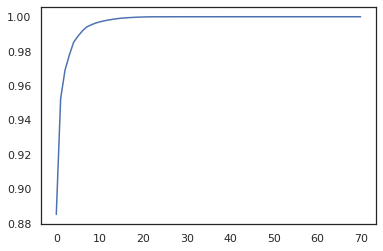

In [ ]:
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)

The curve clearly flattens out near 15 components, and it only takes 15 components to explain about 99% of the variance.

Below we fit the PCA on the training data and transform it.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.20, random_state=42)

# Fit the PCA on the training data
pca = PCA(n_components=15)
pca.fit(X_train)
# and transform it
X_train_2 = pca.transform(X_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(random_state = 42)

parameters = [{'n_estimators':[10, 20, 50, 200], 'max_depth':[2, 10, 50, 100]}]

grid_search = GridSearchCV(estimator=rfr, param_grid=parameters, cv = 3, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params


{'max_depth': 10, 'n_estimators': 200}

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 200, max_depth=10) #10 and 2
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 95.7%


We see that our accuracy has gone up by a little bit! But we'll make use of this new classifer by predicting label data for nutrition_small_df and putting it in 'label2' because we already made a predict for 'label' with our last RandomForestClassifier. This will allow us to compare the two predictions.

In [ ]:
predict_2 = clf.predict(nutrition_small_df.drop(columns=['name', 'label']))

nutrition_small_df['label2'] = predict_2
nutrition_small_df

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,label,label2
0,ANDREA'S,257.0,8.200000,0.000000,0.0,544.000000,0.000000,31.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.140,0.000000,0.000000,0.520000,0.520000,0.000000,41.0,0.1110,0.890000,42.0,0.671000,128.0,165.000000,9.200000,0.770000,5.650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,40.240000,2.90,2.980000,1.55,0.000,1.250,0.000,0.180,0.000,0.000000,0.0000,0.0,0.0,1.310000,0.0,0.0,0,0
1,APPLEBEE'S,296.2,16.420000,4.000000,50.0,770.600000,10.020000,2.800000,0.0,3.008000,0.634000,0.182000,0.084600,106.0,26.2,0.2,11.800000,3.2,25.800000,0.0,0.712,0.256,0.000000,0.000000,1.154000,1.154000,18.480000,85.0,0.0862,1.020000,22.8,0.255600,233.6,204.800000,18.340000,1.854000,15.646,0.799400,0.969800,1.340400,0.203000,3.136600,0.643,0.510000,0.008,0.778,1.352400,1.180200,0.394,0.7128,1.109,0.564800,0.570000,0.191800,0.534400,0.875600,21.396000,1.76,1.742000,0.25,0.054,0.478,0.208,0.456,0.296,4.319000,6.4182,50.0,0.0,2.710000,0.0,0.0,0,0
2,"APPLEBEE'S, chili",157.0,9.800000,4.200000,45.0,381.000000,0.000000,0.000000,0.0,3.557000,0.405000,0.207000,0.037000,1436.0,149.0,0.0,577.000000,200.0,367.000000,0.0,1.260,0.321,1.100000,0.000000,1.150000,1.150000,0.000000,34.0,0.0860,1.460000,18.0,0.084000,104.0,320.000000,13.100000,2.230000,12.560,0.793000,0.772000,1.195000,0.123000,2.070000,0.834,0.371000,0.240,0.556,0.927000,0.844000,0.278,0.4740,0.855,0.371000,0.402000,0.144000,0.340000,0.639000,4.570000,1.40,2.270000,0.98,0.000,1.070,0.000,0.000,0.220,4.809000,0.6440,45.0,0.0,1.760000,0.0,0.0,0,0
3,"APPLEBEE'S, coleslaw",120.0,7.100000,1.100000,2.0,178.000000,0.000000,0.000000,0.0,0.300000,0.205000,0.063000,0.030000,1504.0,77.0,425.0,685.000000,2.0,53.000000,0.0,0.000,0.129,13.700000,0.000000,0.500000,0.500000,65.100000,36.0,0.0170,0.260000,10.0,0.148000,23.0,156.000000,0.400000,0.190000,0.790,0.034000,0.059000,0.068000,0.008000,0.127000,0.017,0.008000,0.000,0.025,0.034000,0.017000,0.008,0.0170,0.006,0.017000,0.017000,0.006000,0.008000,0.034000,13.170000,2.80,9.330000,2.24,0.000,2.530,0.000,0.000,4.560,1.404000,3.8190,2.0,0.0,0.790000,0.0,0.0,0,0
4,"APPLEBEE'S, french fries",290.0,13.000000,2.300000,1.0,618.000000,0.000000,0.000000,0.0,2.180000,0.495000,0.058000,0.103000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.205,0.700000,0.000000,0.930000,0.930000,33.400000,19.0,0.1090,1.010000,29.0,0.268000,137.0,538.000000,0.400000,0.490000,3.310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,39.500000,3.90,0.000000,0.00,0.000,0.000,0.000,0.000,0.000,3.310000,5.8020,1.0,0.0,2.720000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,"Yogurt, skim milk",56.0,0.200000,0.100000,2.0,77.000000,15.200000,12.000000,0.0,0.124000,0.641000,0.234000,0.048000,7.0,2.0,0.0,0.000000,0.0,0.

###4.3 Comparing the two predictions

We can see below how many predictions there are for each, and look at what the differences are.

In [ ]:
nutrition_small_df.label.sum()

521

In [ ]:
nutrition_small_df.label2.sum()

519

The two classifiers do not predict the same number of foods to be healthy. We will look at what the differences are.

In [ ]:
list_1 = nutrition_small_df[(nutrition_small_df['label'] == 1)].name.to_list()
list_2 = nutrition_small_df[(nutrition_small_df['label2'] == 1)].name.to_list()

set_1 = set(list_1)
set_2 = set(list_2)

list_2_items_not_in_list_1 = list(set_1 - set_2)
list_2_items_not_in_list_1

['Spices, tarragon',
 'Fish, ocean, pout',
 'Fireweed, leaves',
 'Carrot',
 'Babyfood, creamed, spinach',
 'Tomatoes, sun-dried',
 'Prunes',
 'Cloudberries',
 'Tomato powder',
 'Sourdock',
 'Lotus root',
 'Tomato products, puree',
 'Spices, fennel seed',
 'Jellies',
 'Spices, anise seed',
 'Crustaceans, blue',
 'Babyfood, peach melba',
 'Vinegar, balsamic',
 'Molasses',
 "CAMPBELL'S, Tomato Soup",
 'Pitanga',
 'Beverages, cola',
 'Yam, or baked',
 'Spinach',
 'Babyfood, dry fortified, barley',
 'Incaparina',
 'Restaurant, lemon chicken',
 'Garlic',
 'Tomatoes, crushed',
 'Beverages, concentrated, Cocktail mix',
 'Parsley',
 'Corn, whole kernel',
 'Mushroom',
 'Babyfood, beets',
 'Arrowroot flour',
 'Durian, raw or frozen',
 'Spinach, chopped or leaf']

For the most part, these differences appear to be on the healthy side, so we will consider our second classifier to have improved! We will keep all items from both lists and look at everything that was labeled healthy by either classifier.

In [ ]:
list_1 = nutrition_small_df[(nutrition_small_df['label'] == 1)].name.to_list()
list_2 = nutrition_small_df[(nutrition_small_df['label2'] == 1)].name.to_list()

set_1 = set(list_1)
set_2 = set(list_2)

combined_list = []
list_2_items_not_in_list_1 = list(set_2 - set_1)
combined_list = list_1 + list_2_items_not_in_list_1
combined_list

['Abiyuch',
 'Acerola',
 'Acerola juice',
 'Agave',
 'Agave, raw (Southwest)',
 'Alcoholic beverage, hard lemonade, malt beer',
 'Alfalfa seeds',
 'Apple juice',
 'Apple juice, undiluted',
 'Apples',
 'Apples, fuji',
 'Apples, gala',
 'Apples, granny smith',
 'Apples, microwave, without skin',
 'Apples, red delicious',
 'Apples, without skin',
 'Applesauce',
 'Apricot nectar',
 'Apricots',
 'Apricots, without skin',
 'Arrowroot',
 'Arrowroot flour',
 'Artichokes',
 'Arugula',
 'Babyfood, apple - cherry',
 'Babyfood, apple and grape',
 'Babyfood, apple and peach',
 'Babyfood, apple and plum',
 'Babyfood, apple and prune',
 'Babyfood, apples with ham',
 'Babyfood, applesauce',
 'Babyfood, banana pudding',
 'Babyfood, banana yogurt',
 'Babyfood, beets',
 'Babyfood, carrots',
 'Babyfood, cherry cobbler',
 'Babyfood, chicken soup',
 'Babyfood, creamed',
 'Babyfood, creamed, spinach',
 'Babyfood, dices, apples',
 'Babyfood, dices, green beans',
 'Babyfood, dices, peaches',
 'Babyfood, dices,

<p align = "center">
<img src = "https://lh3.googleusercontent.com/proxy/bjp0pI7PvikOP4RDSA90eHXSk7mgt9zFBvjNuixhK7lEiMpA8iSpnnzIBhJqwGx0ghYf_5FHx8UZd-vJvnu8sNgNbmia0_tWWw" width= "300" align ="center"/>
</p>

#Part 5: Bringing in Recipe Data

Here we look at recipes.csv





###5.1 Visualizing recipe data

In [ ]:
recipes_df

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,Parmesan Puffs,3.125,28.0,2.0,2.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,Artichoke and Parmesan Risotto,4.375,671.0,22.0,28.0,583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,Turkey Cream Puff Pie,4.375,563.0,31.0,38.0,652.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20050,Snapper on Angel Hair wit

We first notice from the above printout that some recipes are duplicated in the dataset, where the second recipe of the same title listed has multiple NaNs. So, we drop duplicate rows on the data's title column and keep the first.

In [ ]:
recipes_df.drop_duplicates(inplace=True, subset=['title'], keep='first')

Let's see how many recipes have extremely high ratings. Out of 16168 rows, we see that 9484 have ratings with 4 stars or above, and out of those, 2304 of them have perfect 5 star ratings. Wecan see this using the interactive dataframe below that allows a user to view recipes based on the fewest stars (lowest rating) they are willing to accept.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_df(column='rating', x=(0, 5, 0.1)):
    return recipes_df.loc[recipes_df[column] >= x]

interactive(children=(Text(value='rating', description='column'), FloatSlider(value=2.0, description='x', max=…

We visualize this in a histogram below and can see that most of the recipes have around 4 stars, although some seem to be particularly terrible (if at all bad) with less than 1 star.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c5abe80b8>]],
      dtype=object)

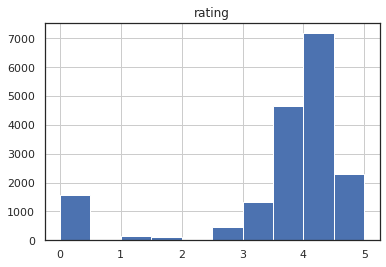

In [ ]:
recipes_df.hist(column=['rating'])

Now we want to make an interactive dataframe visualizer so that if the "switch" is on 1, then all recipes with the selected tag will appear, and if on 0, all recipes that do not contain the selected tag will appear.

In [ ]:
@interact
def show_df(column=list(recipes_df.drop(columns=['sodium', 'protein', 'calories', 'fat', 'rating', 'title']).columns), x=(0, 1, 1)):
    return recipes_df.loc[(recipes_df[column] == x)]

interactive(children=(Dropdown(description='column', options=('#cakeweek', '#wasteless', '22-minute meals', '3…

###5.2 Identify healthy recipe tags

We can see that in recipes_df, recipes have tags that indicate what ingredients are used for a particular recipe. So, we want to figure out which tags correspond with the rows from nutrition_small_df, so that we can indicate which columns are healthy tags in recipes_df. 

Also note that because of our string comparisons and the extra terms that occur in the names of ingredients from nutrition_small_df, there are some terms that are not ingredients, so we want to remove those, which are determined after printing out the relevant columns.

In [ ]:
healthy_cols = []

for item in recipes_df.columns.to_list():
  if any(item in x for x in combined_list):
      healthy_cols.append(item)
  

irrelevant_terms = ['bake', 'boil', 'brine', 'breakfast','lunch', 'japan', 'low carb', 'chill', 'microwave', 'maine', 'organic', 'dessert', 'tart']

for term in irrelevant_terms:
  if term in healthy_cols:
    healthy_cols.remove(term)

healthy_cols

['almond',
 'anise',
 'apple',
 'apple juice',
 'apricot',
 'artichoke',
 'banana',
 'barley',
 'basil',
 'bass',
 'bean',
 'beer',
 'beet',
 'berry',
 'bread',
 'broccoli',
 'butter',
 'cantaloupe',
 'carrot',
 'celery',
 'cheese',
 'cherry',
 'chestnut',
 'chicken',
 'chile',
 'chili',
 'cilantro',
 'cocktail',
 'coconut',
 'cod',
 'coriander',
 'corn',
 'cucumber',
 'dill',
 'drink',
 'egg',
 'fennel',
 'fish',
 'fruit',
 'fruit juice',
 'gin',
 'ginger',
 'grape',
 'grapefruit',
 'green bean',
 'halibut',
 'ham',
 'honey',
 'honeydew',
 'kiwi',
 'lemon',
 'lima bean',
 'lime',
 'lobster',
 'mango',
 'meat',
 'melon',
 'mint',
 'mustard',
 'nut',
 'octopus',
 'onion',
 'orange',
 'oregano',
 'paprika',
 'parsley',
 'pea',
 'peach',
 'pear',
 'pepper',
 'pineapple',
 'plantain',
 'plum',
 'potato',
 'prune',
 'pumpkin',
 'punch',
 'raw',
 'rice',
 'roast',
 'rum',
 'salad',
 'salsa',
 'sauce',
 'scallop',
 'seed',
 'smoothie',
 'snapper',
 'spice',
 'spinach',
 'tarragon',
 'thyme',


###5.3 Find healthy and highly rated recipes

We will suggest recipes as "healthy" if they contain at least 8 of the tags we've labeled as healthy. This ensures that the majority of the ingredients in the recipe are healthy ingredients.

In [ ]:
recipe_map = {}
for index, row in recipes_df.iterrows():
    for col in healthy_cols:
      if row[col] == 1.0:
        # print(col)
        # print(row['title'])
        if row['title'] in recipe_map:
          recipe_map[row['title']] = recipe_map[row['title']] + 1
        else:
          recipe_map[row['title']] = 1

recipe_list = []
for recipe in recipe_map:
  if recipe_map[recipe] > 7:
    recipe_list.append(recipe)
recipe_list

['Grilled Vegetable Antipasto with Herbed Chevre and Crostini ',
 'Florida Ambrosia Salad ',
 'Whole Branzino Roasted in Salt ',
 'Lobster and Shrimp Cioppino ',
 'Tandoori Tilapia with Hearts of Palm Salad ',
 "Dean & Deluca's Tuna Sandwich with Carrots, Red Onion, and Parsley ",
 'Cream of Tomato Soup with Souffléed Cheese Toasts ',
 'Apricot Pistachio Fruitcakes ',
 'Sauteed Halibut with Lemon-Vegetable Relish ',
 'Philadelphia Fish House Punch ',
 'Cabbage and Corn Slaw with Cilantro and Orange Dressing ',
 'Spicy Tomato, Pepper, Cucumber, Mint, and Parsley Salad ',
 'Fresh Herb Platter (Sabzi Khordan) ',
 'Tom Collins Bar ',
 'Green Apple and Celery Salad with Walnuts and Mustard Vinaigrette ',
 'Mexican Pasta Salad ',
 'Chocolate-Hazelnut Panforte ',
 'Gravy Base ',
 'Beet Salad with Plums and Goat Cheese ',
 'Tropical Holiday Crowns ',
 'Minted Mai Tai ',
 'Roasted Whole Fish and Fennel with Crushed Potatoes, Perserved Lemon, and Charmoula ',
 'Chowders ',
 'A Nice Vegetable Sou

Now, we don't want to suggest recipes that have a low rating, so we will remove all recipes that have lower than a 4.0 star rating.

In [ ]:
best_recipes_list = []
for index, row in recipes_df.iterrows():
  if row['title'] in recipe_list:
    if row['rating'] >= 4:
        best_recipes_list.append(row['title'])
best_recipes_list

['Grilled Vegetable Antipasto with Herbed Chevre and Crostini ',
 'Whole Branzino Roasted in Salt ',
 'Lobster and Shrimp Cioppino ',
 "Dean & Deluca's Tuna Sandwich with Carrots, Red Onion, and Parsley ",
 'Apricot Pistachio Fruitcakes ',
 'Sauteed Halibut with Lemon-Vegetable Relish ',
 'Cabbage and Corn Slaw with Cilantro and Orange Dressing ',
 'Spicy Tomato, Pepper, Cucumber, Mint, and Parsley Salad ',
 'Green Apple and Celery Salad with Walnuts and Mustard Vinaigrette ',
 'Chocolate-Hazelnut Panforte ',
 'Gravy Base ',
 'Beet Salad with Plums and Goat Cheese ',
 'Minted Mai Tai ',
 'Roasted Whole Fish and Fennel with Crushed Potatoes, Perserved Lemon, and Charmoula ',
 "Jacques's French Potato Salad ",
 'Haddock in Charmoula Sauce ',
 'My Green Papaya Salad ',
 'Sea Bass with Roasted Tomatoes and Green Beans ',
 'Smoked Ham, Barley, and Vegetable Soup ',
 'Chicken Tagine with Spring Vegetables ',
 'Tuscan Panzanella ',
 'Spinach Salad with Oranges and Warm Goat Cheese ',
 'Asiago

Through this process, we have deemed the ~30 recipes in best_recipe_list to be the "best" recipes in all of recipes_df!

<p align = "center">
<img src = "https://us.123rf.com/450wm/ainesy/ainesy1910/ainesy191000054/132955204-stock-vector-vegetables-market-with-shelves-and-prices-eco-supermarket-ripe-healthy-organic-grocery-store-vector-.jpg?ver=6" width= "500" align ="center"/>
</p>

#Part 6: Rank Top Recipes By Price

We will use prices_df to assign each recipe in "best_recipe_list" a price based on the price of the ingredients within. 

###6.1 Modify dataframes and create price and ingredient mappings

First we note that we don't need any data from prices_df besides the item name ('itemdesc') and the item cost ('totitemcost'), so we drop all other columns.

In [ ]:
prices_df.drop(columns=['hhnum', 'eventid', 'itemnum', 'bundlenum', 'bundletype', 'menugrp',
       'nonschmealitem', 'itemdescsource',
       'quantity_flag', 'size', 'size_flag', 'sizeunit', 'sizeunit_flag',
       'sizerelative', 'additem_flag', 'itemcost',
       'itemcost_flag', 'free', 'free_flag2', 'impitemcost',
       'impcostmethod', 'imptotcost', 'quantity', 'gramstotal'], inplace=True)
prices_df

,itemdesc,totitemcost
0,Double Cheeseburger,0.00
1,"REGULAR SODA, SPRITE, SIERRA MIST, MOUNTAIN DEW",1.50
2,PICKLE,0.00
3,TURKEY SANDWICH,0.00
4,"JUICE, APPLE",0.00
...,...,...
116069,"Original Chicken, Thigh",2.99
116070,BREAKFAST TACO,1.49
116071,PIE SHELL,7.16
116072,"REGULAR SODA, COCA COLA, COKE, PEPSI",1.59


Now, we need to make a mapping from a recipe to a list of all the ingredients in that recipe so that we can assign it a price based on the price of individual ingredients. 

In [ ]:
row_map = {}
def get_col_name(row):    
    col_list = []
    if row.title in best_recipes_list:
      for col in recipes_df.drop(columns=['rating', 'sodium', 'protein', 'fat', 'calories']).columns.to_list():
        if row[col] == 1:
          col_list.append(col)
          
      row_map[row.title] = col_list

recipes_df.apply(get_col_name, axis=1)
row_map

{'Apricot Pistachio Fruitcakes ': ['apricot',
  'bake',
  'bon appétit',
  'bourbon',
  'cake',
  'christmas',
  'coconut',
  'dessert',
  'dried fruit',
  'fruit',
  'kosher',
  'mixer',
  'nut',
  'peach',
  'peanut free',
  'pescatarian',
  'pineapple',
  'pistachio',
  'raisin',
  'soy free',
  'spice',
  'tropical fruit',
  'vegetarian',
  'winter'],
 'Asiago Cheese with Glazed Cipolline Onions ': ['butter',
  'cheese',
  'fall',
  'fontina',
  'fruit',
  'honey',
  'onion',
  'orange',
  'parmesan',
  'quick & easy',
  'raisin',
  'sherry',
  'side',
  'spring',
  'summer',
  'thyme',
  'vegetable',
  'vinegar',
  'winter'],
 'Beet Salad with Plums and Goat Cheese ': ['appetizer',
  'beet',
  'bon appétit',
  'cheese',
  'dinner',
  'fruit',
  'goat cheese',
  'kosher',
  'lunch',
  'peanut free',
  'pescatarian',
  'picnic',
  'plum',
  'roast',
  'salad',
  'soy free',
  'spinach',
  'summer',
  'vegetable',
  'vegetarian',
  'wheat/gluten-free'],
 'Cabbage and Corn Slaw with C

We now make a mapping from item in prices_df to its cost for easy comparison.

In [ ]:
item_to_price = {}
def get_price(row):    
    item_to_price[row.itemdesc.lower()] = row.totitemcost


prices_df.apply(get_price, axis=1)
item_to_price

{'double cheeseburger': 1.49,
 'regular soda, sprite, sierra mist, mountain dew': 1.69,
 'pickle': 0.0,
 'turkey sandwich': 0.0,
 'juice, apple': 0.0,
 'cool ranch doritos': 0.0,
 'sausage biscuit': 0.0,
 'strawberry poptart': 1.0,
 'cheetos': 0.0,
 'french fries': 0.0,
 'spaghetti or pasta with sauce': 0.0,
 'potato chips': 0.0,
 'crunch bar': 1.0,
 'water, nfs': 0.0,
 'ice cream sandwich or bar (any type)': 3.18,
 'bbq rib sandwich': 0.0,
 'pepperoni, pan pizza': 4.0,
 'strawberry pop tart': 0.0,
 'half chill pear': 0.0,
 'corn dog': 0.0,
 'garden salad': 0.0,
 'cheesey broccoli': 0.0,
 'jello': 0.0,
 'dressing': 0.0,
 'chips (other or unknown type)': 0.0,
 'diet soda, sprite, sierra mist, mountain dew': 1.69,
 'honey bun': 0.69,
 'pop tart': 0.0,
 'peach slices': 0.0,
 'pizza, cheese': 0.0,
 'orange': 0.0,
 'mashed potatoes': 0.0,
 'steak': 0.0,
 'lima beans': 0.0,
 'regular soda, dr pepper, root beer': 0.0,
 'mexican pizza': 2.99,
 'waffle (plain or flavored)': 0.0,
 'sausage and b

Unfortunately, we can see here that many of the items have a listed price of 0.0, and some are NaN. Since we have no way of filling in these 0's and NaN's with legitimate prices, we won't be able to count in the cost of the recipe any ingredient that is listed as cost 0 or NaN.

Anyway, we make two additional DataFrames with no information aside from the ingredient. In ingredients_df we have all ingredients from recipes in best_recipes, and in list_df we have all the names of items in the prices_df.

In [ ]:
l = []
for i in row_map:
  for j in row_map[i]:
    l.append(j)
l
ingredients_df = pd.DataFrame(l, columns=['name'])
ingredients_df.drop_duplicates(inplace=True)
ingredients_df
list_df = pd.DataFrame(list(item_to_price), columns=['name'])
ingredients_df.reset_index(inplace=True)
list_df.reset_index(inplace=True)
list_df

,index,name
0,0,double cheeseburger
1,1,"regular soda, sprite, sierra mist, mountain dew"
2,2,pickle
3,3,turkey sandwich
4,4,"juice, apple"
...,...,...
19442,19442,chop house cheddar burger jr.
19443,19443,all can eat buffet
19444,19444,juice box fruit punch flavored
19445,19445,egg and cheese biscuits


###6.2 Compare with Jaccard similarity

Our goal now is to figure out which ingredient terms (originally from recipes_df) match with which food item terms (from prices_df). We will do this through finding pairwise Jaccard similarity, using the two dataframes we just created.

We choose to do a Jaccard join here because there are variations in how the terms are written, for example, some are plural, some are comma separated, etc, so comparing via Jaccard similarity allows us to create our own cutoff for how similar the terms must be, to be considered the same. The cutoff we choose is 0.35.

In [ ]:
tok = sm.QgramTokenizer(qval=5,return_set=True)
answer_df = ssj.jaccard_join(ingredients_df, list_df, 'index', 'index', 'name', 'name', tok, 0.35, 
                                l_out_attrs=['name'], r_out_attrs=['name'])
answer_df.drop(columns=['l_index','r_index','_id'], inplace=True)
answer_df.drop_duplicates(inplace=True)
answer_df

/usr/local/lib/python3.6/dist-packages/py_stringsimjoin/utils/validation.py:30: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,l_name,r_name,_sim_score
0,orange,orange,1.000000
1,green bean,green beans,0.526316
2,chocolate,chocolate milkshake,0.384615
3,cake,cake,1.000000
4,mustard,mustard,1.000000
...,...,...,...
616,chocolate,chocolate yoghurt,0.360000
617,chocolate,chocolate chip,0.409091
618,artichoke,artichoke hearts,0.375000
619,vegetable,vegetable dip,0.428571


Add the price column back into this dataset.

In [ ]:
def get_cost(col):
  return item_to_price[col]


answer_df['price'] = answer_df['r_name'].apply(get_cost)
answer_df

,l_name,r_name,_sim_score,price
0,orange,orange,1.000000,0.00
1,green bean,green beans,0.526316,2.00
2,chocolate,chocolate milkshake,0.384615,0.00
3,cake,cake,1.000000,1.50
4,mustard,mustard,1.000000,0.00
...,...,...,...,...
616,chocolate,chocolate yoghurt,0.360000,0.00
617,chocolate,chocolate chip,0.409091,0.00
618,artichoke,artichoke hearts,0.375000,20.00
619,vegetable,vegetable dip,0.428571,0.00


Since the l_name column are the ingredients that came from recipes_df, which we will be referring back to, to determine each element's price, we no longer need r_name of _sim_score so we drop these columns.

Furthermore, we group by 'l_name' so that if there were multiple similar matches for one ingredient, we take all matches into account. The price adjustment we choose here when we group is to take the mean price among the prices that we may need to group together, as this will account for price differences between similar items made with the same ingredient.

Finally, we fill the NaNs with 0 and reset the index.

In [ ]:
answer_df = answer_df.drop(columns=['r_name', '_sim_score']).groupby('l_name').mean().fillna(0, axis=0)
answer_df.reset_index(inplace=True)

###6.3 Display final prices
We can now create our final mapping from ingredient to its price.

In [ ]:
ingr_to_price = {}
def get_price(row):    
    ingr_to_price[row.l_name] = row.price


answer_df.apply(get_price, axis=1)
ingr_to_price

{'alcoholic': 7.0,
 'almond': 0.99,
 'appetizer': 5.194,
 'apple': 0.33166666666666667,
 'apricot': 0.0,
 'artichoke': 3.7550000000000003,
 'arugula': 8.99,
 'backyard bbq': 3.5,
 'basil': 0.49,
 'bass': 0.0,
 'bell pepper': 0.25,
 'bourbon': 4.583333333333333,
 'bread': 0.5,
 'butter': 3.5566666666666666,
 'cabbage': 0.0,
 'cake': 0.47800000000000004,
 'carrot': 0.5599999999999999,
 'celery': 0.0,
 'cheese': 1.1624999999999999,
 'chicken': 4.392363636363636,
 'chile pepper': 0.0,
 'chocolate': 1.1261,
 'cilantro': 0.545,
 'cocktail': 1.4583333333333333,
 'coconut': 0.0,
 'corn': 1.25,
 'crab': 0.0,
 'cucumber': 0.0,
 'curry': 9.0,
 'dessert': 9.0,
 'dinner': 3.25,
 'dried fruit': 1.6666666666666667,
 'drink': 0.0,
 'egg': 0.0,
 'fig': 0.0,
 'fish': 4.616666666666666,
 'fruit': 0.0,
 'fruit juice': 0.29923076923076924,
 'garlic': 0.96,
 'goat cheese': 3.0,
 'green bean': 0.436875,
 'grill/barbecue': 0.0,
 'halibut': 9.95,
 'ham': 0.0,
 'hazelnut': 0.5,
 'healthy': 1.99,
 'honey': 0.0,


This mapping then allows us to calculate a cumulative price for each recipe, which we do by iterating through all the ingredients listed as tags for a recipe and adding the prices of those ingredients.

In [ ]:
recipe_to_price = {}
for recipe in row_map:
  price = 0
  for ing in row_map[recipe]:
    if (ing in ingr_to_price):
      price = price + ingr_to_price[ing]
  recipe_to_price[recipe] = price

recipe_to_price


{'Apricot Pistachio Fruitcakes ': 25.993544096728307,
 'Asiago Cheese with Glazed Cipolline Onions ': 16.308364527629234,
 'Beet Salad with Plums and Goat Cheese ': 23.70427840322732,
 'Cabbage and Corn Slaw with Cilantro and Orange Dressing ': 14.248005675954591,
 'Chicken Tagine with Spring Vegetables ': 9.667363636363635,
 'Chocolate-Hazelnut Panforte ': 3.418827272727273,
 "Dean & Deluca's Tuna Sandwich with Carrots, Red Onion, and Parsley ": 11.796613475177306,
 'Gravy Base ': 7.79883422459893,
 'Green Apple and Celery Salad with Walnuts and Mustard Vinaigrette ': 11.759505675954593,
 'Grilled Vegetable Antipasto with Herbed Chevre and Crostini ': 18.360839009287925,
 'Haddock in Charmoula Sauce ': 8.444166666666666,
 "Jacques's French Potato Salad ": 27.644035087719296,
 'Lobster and Shrimp Cioppino ': 36.58,
 'Minted Mai Tai ': 10.175967050967051,
 'My Green Papaya Salad ': 12.124842342342342,
 'Roasted Chicken with Carrots, Turnips, and Zucchini ': 9.081834224598929,
 'Roasted 

Lastly, we sort from least to greatest price.

In [ ]:
from collections import OrderedDict
dd = OrderedDict(sorted(recipe_to_price.items(), key=lambda x: x[1]))
dd

OrderedDict([('Roasted Whole Fish and Fennel with Crushed Potatoes, Perserved Lemon, and Charmoula ',
              0.0),
             ('Smoked Ham, Barley, and Vegetable Soup ', 0.996875),
             ('Chocolate-Hazelnut Panforte ', 3.418827272727273),
             ('Gravy Base ', 7.79883422459893),
             ('Haddock in Charmoula Sauce ', 8.444166666666666),
             ('Roasted Chicken with Carrots, Turnips, and Zucchini ',
              9.081834224598929),
             ('Chicken Tagine with Spring Vegetables ', 9.667363636363635),
             ('Shirazi Salad ', 10.039035087719299),
             ('Minted Mai Tai ', 10.175967050967051),
             ('Green Apple and Celery Salad with Walnuts and Mustard Vinaigrette ',
              11.759505675954593),
             ("Dean & Deluca's Tuna Sandwich with Carrots, Red Onion, and Parsley ",
              11.796613475177306),
             ('My Green Papaya Salad ', 12.124842342342342),
             ('Cabbage and Corn Slaw with Ci

Note that the issue here is that if there are no matches in the price_df for any of the ingredients in a recipe, then it will output that the price for the recipe is 0.0, which we see for the Roasted Fish recipe at the top. This may also happen if the listed prices in prices_df were 0.0 for all the ingredients, which we saw above could be true.

Clearly no recipe cannot have cost 0, so ideally in the future I will be able to find a more comprehensive and accurate dataset!

#Part 7: Build a More General Classifier

The first two classifiers we created were heavily geared towards this particular dataset, which we can see because of the high accuracy. We would also expect this behavior due to the large disparity between the sizes of our healthy list of foods and unhealthy list.

###7.1 Make the sets more even

We will make the healthy and unhealthy sets have closer to the same number of elements. We will make it ~ 50%/50% (healthy/unhealthy) split by taking a random sample of the larger unhealthy dataset.

In [ ]:
import random
from random import sample

healthy_small_df = pd.DataFrame()
healthy_small_df = nutrition_small_df.copy()
healthy_small_df.drop(columns=['label', 'label2'])

shortened_unhealthy_list = sample(unhealthy_foods, int(len(healthy_foods)))

def find_food2(col):
  for food in healthy_foods:
    if food in col:
      return 1
  for food in shortened_unhealthy_list:
    if food == col:
      return 0
  return 2

healthy_small_df['label'] = healthy_small_df.name.apply(find_food2)
healthy_small_df = healthy_small_df[healthy_small_df['label'] != 2]
healthy_small_df['label'].value_counts()

0    161
1    149
Name: label, dtype: int64

###7.2 Predicting with more even training data

Now we follow the exact same process of PCA and RandomForestClassifier creation as before.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_final = healthy_small_df.drop(columns=['name', 'label'])

X_final = StandardScaler().fit_transform(X_final)

label_final = healthy_small_df.label
pca_final = PCA(n_components=features.columns.size)
X2_final = pca_final.fit_transform(X_final)

In this case, we followed the Unsupervised Learning example notebook from lecture and scaled the data using the StandardScaler.

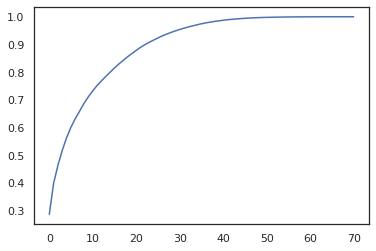

In [ ]:
pc_vs_variance = np.cumsum(pca_final.explained_variance_ratio_)

pc_vs_variance
plt.plot(pc_vs_variance)

With the data scaled here, now we need about 45 components to explain 95% of  the variance.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, label_final, test_size=0.30, random_state=42)

# Fit the PCA on the training data
pca_final = PCA(n_components=45)
pca_final.fit(X_train)
# and transform it
X_train_2 = pca_final.transform(X_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(random_state = 42)

parameters = [{'n_estimators':[10, 20, 50, 200], 'max_depth':[2, 10, 50, 100]}]

grid_search = GridSearchCV(estimator=rfr, param_grid=parameters, cv = 3, n_jobs = -1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params


{'max_depth': 10, 'n_estimators': 200}

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 200, max_depth=10)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 93.5%


As we can see, our accuracy has gone down a bit, so hopefully this means there will be less overfitting.

In [ ]:
predict_2 = clf.predict(nutrition_small_df.drop(columns=['name', 'label']))

nutrition_small_df['label2'] = predict_2

In [ ]:
nutrition_small_df[nutrition_small_df['label2'] == 1].name.to_list()

['Abiyuch',
 'Acerola',
 'Acerola juice',
 'Agave',
 'Agave, raw (Southwest)',
 'Alcoholic beverage, hard lemonade, malt beer',
 'Alfalfa seeds',
 'Apple juice',
 'Apple juice, undiluted',
 'Apples',
 'Apples, fuji',
 'Apples, gala',
 'Apples, granny smith',
 'Apples, microwave, without skin',
 'Apples, red delicious',
 'Apples, without skin',
 'Applesauce',
 'Apricot nectar',
 'Apricots',
 'Apricots, without skin',
 'Arrowroot',
 'Artichokes',
 'Arugula',
 'Asparagus',
 'Babyfood, apple - cherry',
 'Babyfood, apple and grape',
 'Babyfood, apple and peach',
 'Babyfood, apple and plum',
 'Babyfood, apple and prune',
 'Babyfood, apples with ham',
 'Babyfood, applesauce',
 'Babyfood, banana pudding',
 'Babyfood, banana yogurt',
 'Babyfood, carrots',
 'Babyfood, cherry cobbler',
 'Babyfood, chicken soup',
 'Babyfood, creamed',
 'Babyfood, dices, apples',
 'Babyfood, dices, green beans',
 'Babyfood, dices, peaches',
 'Babyfood, dices, pears',
 'Babyfood, dices, peas',
 'Babyfood, dry fortif

Looking at the list of foods printed above that our new classifier has designated as "healthy", there are a couple out of place. The classifier doesn't acheive exactly what we want it to, even though the accuracy is still pretty high.

This is because our training sets and testing sets are so small. Since there were very few healthy foods in the dataset, and our sources for reliable "health foods" were only the 100 most nutritious foods and an additional ~50 fruits, we had to scale down our unhealthy dataset to match the size of the healthy dataset. 

This resulted in poorer classification because the list of unhealthy foods will no longer be able to represent the wide range of unhealthy foods (either due to high carbs, high sugar, high total fat, or high saturated fat) since foods of these categories have been removed entirely to get a better 50/50 balanced training/testing sets.

If I were to do this again, I would find a larger nutrition dataset and a larger list of healthy foods, or classify healthy foods the same way that I classified unhealthy foods to get a larger set (by testing parameters and visualizing what data is left after a certain threshold). 

#Part 8: Challenges and Next Steps

The biggest challenge I faced was finding suitable methods of manipulating the datasets in ways that did not decrease the dataset's value. This is most notable in the changing of the name that I perform in nutrition_small_df. I ended up doing this because it allowed me to later on use the string comparison method to find which columns in recipes_df should be marked as healthy. It also made it easier to understand the dataframe when printing out entries, and trying to figure out health cutoffs. 

I also faced the challenge of how to meaningfully combine observations from nutrition_df, recipes_df, and prices_df to make this more useful for a user. Each of the datasets had limitations, for example, some of the prices in prices_df were listed as 0.0. These individual limitations also made it difficult to combine the data because there was not as much overlapping data between the sets as I had originally hoped.

In the future, as I mentioned before, I'd like to bring in a much larger dataset so that I can train my model and have it work on more general cases, while still maintaining fair accuracy on the original dataset. That way I would not be limited by a mere 150 healthy foods on which to train the RandomForestClassifier.

Furthermore, I would find a more accurate prices dataset so as not to have any recipes be listed at $0. I would also find a way to use the serving size in a recipe, combined with the serving size for the price of the product listed, so that the price for a recipe becomes more meaninful in how many servings it makes for how much money.

Lastly, I'd love to learn a more scientific way of calculating a cutoff for "unhealthy" foods rather than testing and checking the results with suger/fat/carb maximums. I could then replace my original unhealthy cutoff with a more tested and proven version. Although this new version would definitely include the foods that I had in the set, as they were clearly items like cake and cookies, the new method would perhps allow for classification of a wider range of items as unhealthy.



![alt text](https://webstockreview.net/images/athlete-clipart-nutrition-14.png)